In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [3]:
from models.Wang2020 import M2_1
net = M2_1(N_layers=8, width=32, activation=nn.ELU()).to(device)

In [4]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
#train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

RandomMeshSDFDataset (10000 points)


In [5]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [6]:
use_random_sdf = isinstance(train_dataset, RandomMeshSDFDataset)
points = train_dataset.points if use_random_sdf else train_dataset.pde_points
sdfs = train_dataset.sdfs if use_random_sdf else train_dataset.bc_sdfs

In [8]:
#torch.autograd.set_detect_anomaly(True)
max_epochs = 2500
PRINT_EVERY_EPOCH = 100
points.requires_grad_(True)
try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        y = net(points)
        loss = net.loss(y, points, points, sdfs)
        loss.backward(retain_graph=True)
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)
        
        if epoch % 20 == 19:
            y = net(points)
            net.adaptive_lambda(y, points, points, sdfs)

        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}, {net.loss_lambda[0]:.6f}')
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.713803, 0.374835, 1.000000
#100 Loss: 0.140002, 0.016460, 6.121566
#200 Loss: 0.115546, 0.006520, 11.253932
#300 Loss: 0.097295, 0.005248, 10.999681
#400 Loss: 0.097369, 0.004373, 13.332679
#500 Loss: 0.087261, 0.004083, 12.771010
#600 Loss: 0.094244, 0.003832, 14.940852
#700 Loss: 0.099360, 0.003651, 16.737305
#800 Loss: 0.102566, 0.003511, 18.095201
#900 Loss: 0.104486, 0.003402, 19.117638
#1000 Loss: 0.105443, 0.003317, 19.881157
#1100 Loss: 0.107002, 0.003287, 20.450859
#1200 Loss: 0.107998, 0.003261, 20.863539
#1300 Loss: 0.108577, 0.003237, 21.159172
#1400 Loss: 0.108877, 0.003217, 21.374386
#1500 Loss: 0.108894, 0.003200, 21.502541
#1600 Loss: 0.093517, 0.002718, 22.284492
#1700 Loss: 0.087961, 0.002265, 24.130594
#1800 Loss: 0.081691, 0.001889, 25.708218
#1900 Loss: 0.075246, 0.001655, 25.683983
#2000 Loss: 0.067181, 0.001490, 24.330845
#2100 Loss: 0.061153, 0.001462, 22.344219
#2200 Loss: 0.057380, 0.001404, 21.359634
#2300 Loss: 0.054536, 0.001367, 20.943571
#2400 

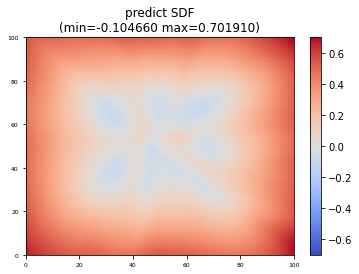

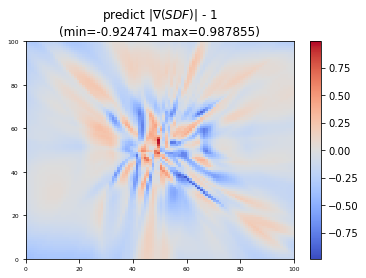

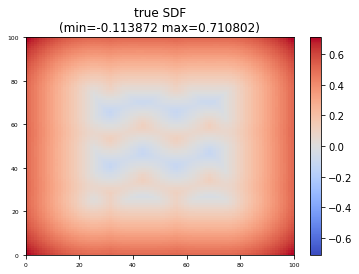

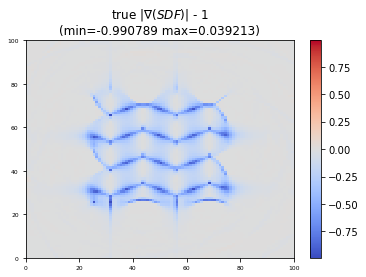

In [9]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)